In [2]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import terratorch
import torch
import torchgeo 
import tqdm as notebook_tqdm

#import geopandas as gpd
import pandas as pd

import sys
sys.path.append('../')


import utils.basics as bsc
import utils.plotting as pt

import importlib
importlib.reload(pt)

%load_ext autoreload
%autoreload 2

/Users/felix/miniconda3/envs/CHM/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load the data

In [3]:
# === Paths ===
INPUT_FOLDER = "../data/03_training"

In [4]:
def load_and_split_patches(site, patch_size=32, test_size=0.2, random_state=42):
    """
    Load S2 and ALS patches for a given site, split into train/test sets.

    Parameters:
    - site: int (1 or 2)
    - patch_size: int
    - test_size: float
    - random_state: int

    Returns:
    - X_train, X_test, y_train, y_test
    """
    s2_patches = np.load(os.path.join(INPUT_FOLDER, f"S2_site{site}_px{patch_size}.npy"))
    als_patches = np.load(os.path.join(INPUT_FOLDER, f"ALS_site{site}_px{patch_size}.npy"))
    X_train, X_test, y_train, y_test = train_test_split(
        s2_patches, als_patches, test_size=test_size, random_state=random_state
    )
    print(f"Site {site}: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Site {site}: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    return X_train, X_test, y_train, y_test

# Execute for site 1 and 2
X_train1, X_test1, y_train1, y_test1 = load_and_split_patches(site=1)
X_train2, X_test2, y_train2, y_test2 = load_and_split_patches(site=2)

Site 1: X_train shape: (288, 13, 32, 32), y_train shape: (288, 32, 32)
Site 1: X_test shape: (72, 13, 32, 32), y_test shape: (72, 32, 32)
Site 2: X_train shape: (255, 13, 32, 32), y_train shape: (255, 32, 32)
Site 2: X_test shape: (64, 13, 32, 32), y_test shape: (64, 32, 32)


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
import pytorch_lightning as pl

# Custom ResNet18 for regression
class ResNet18Regression(pl.LightningModule):
    def __init__(self, in_channels=13, out_channels=1, lr=2e-3):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        # Get resnet18, no pretrained weights
        self.model = resnet18(weights=None)
        # Change first conv to accept 13 channels
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=True)
        # Remove the classifier, add a conv to output 1 channel
        self.model.fc = nn.Identity()
        self.reg_head = nn.Conv2d(512, out_channels, kernel_size=1)
        
    def forward(self, x):
        # ResNet expects at least 224x224, but we use 32x32, so we skip pooling
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        # Remove maxpool to keep spatial dims
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.reg_head(x)
        # Upsample to 32x32 if needed
        x = F.interpolate(x, size=(32, 32), mode='bilinear', align_corners=False)
        return x.squeeze(1)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Prepare data as torch Dataset
class PatchDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        # X: (13, 32, 32), y: (32, 32)
        return self.X[idx], self.y[idx]

train_ds = PatchDataset(X_train2, y_train2)
val_ds = PatchDataset(X_test2, y_test2)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16)

# Train with PyTorch Lightning
model = ResNet18Regression(in_channels=13, out_channels=1)
trainer = pl.Trainer(max_epochs=20, accelerator='auto',log_every_n_steps=1)
trainer.fit(model, train_loader, val_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type   | Params | Mode 
--------------------------------------------
0 | model    | ResNet | 11.2 M | train
1 | reg_head | Conv2d | 513    | train
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.834    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/felix/miniconda3/envs/CHM/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/Users/felix/miniconda3/envs/CHM/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 16/16 [00:00<00:00, 35.10it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 16/16 [00:00<00:00, 26.92it/s, v_num=4]


In [18]:
# write the evaluation code, i want to see loss over training and overall performance
# Evaluate the model on the test set
test_ds = PatchDataset(X_test2, y_test2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=16)
# Evaluate the model
trainer.validate(model, test_loader)
# Plot training and validation loss
def plot_training_history(trainer):
    # Extract training history
    train_loss = trainer.logged_metrics['train_loss']
    val_loss = trainer.logged_metrics['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()
plot_training_history(trainer)

Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 138.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     46.37663269042969     │
└───────────────────────────┴───────────────────────────┘

KeyError: 'train_loss'

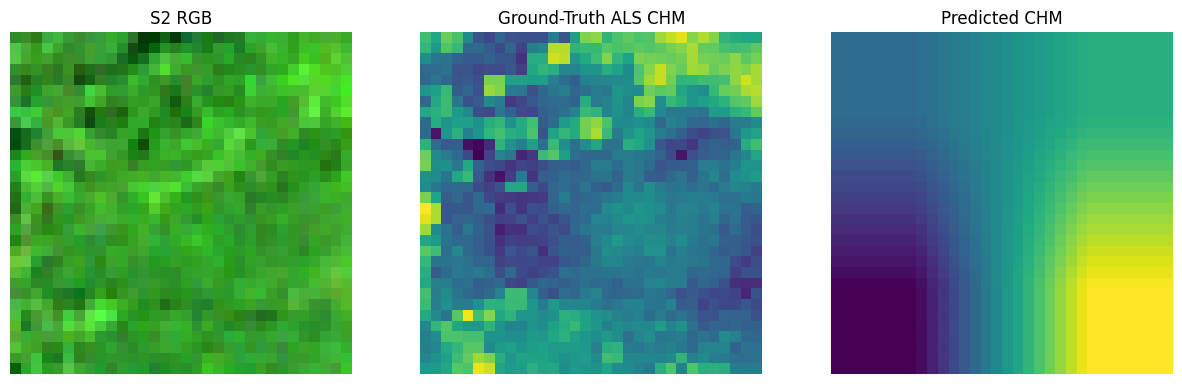

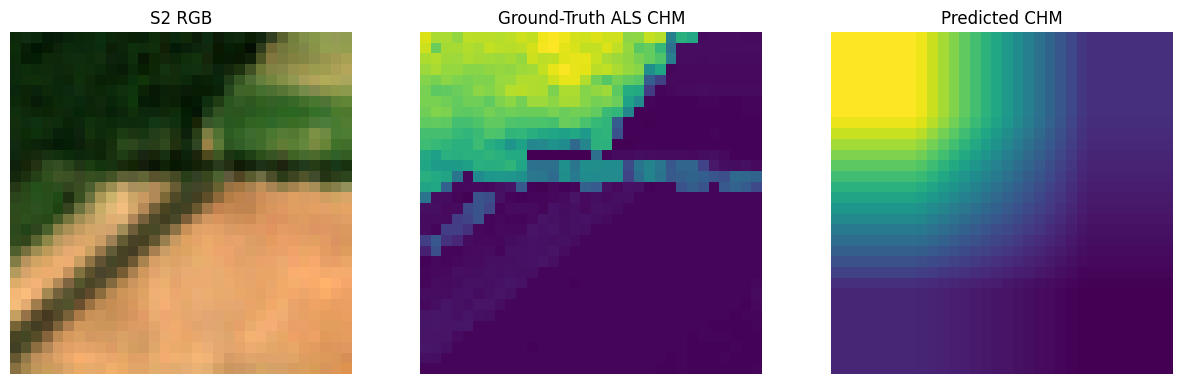

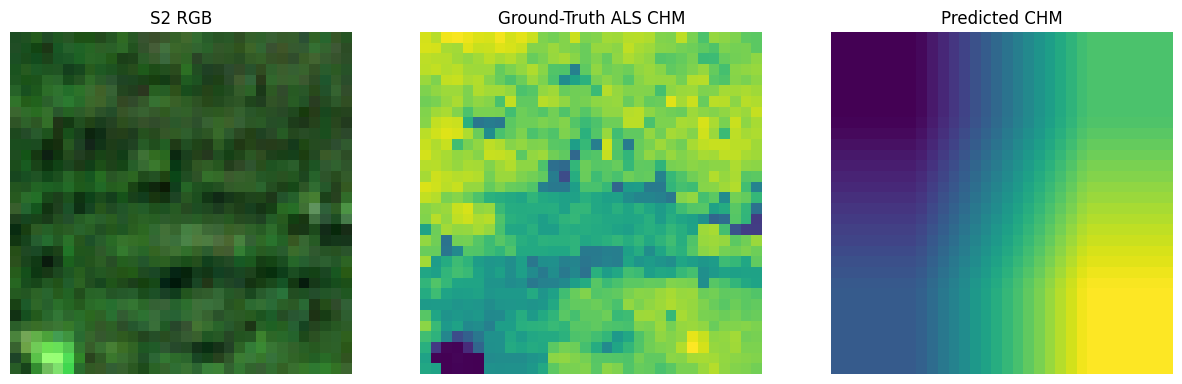

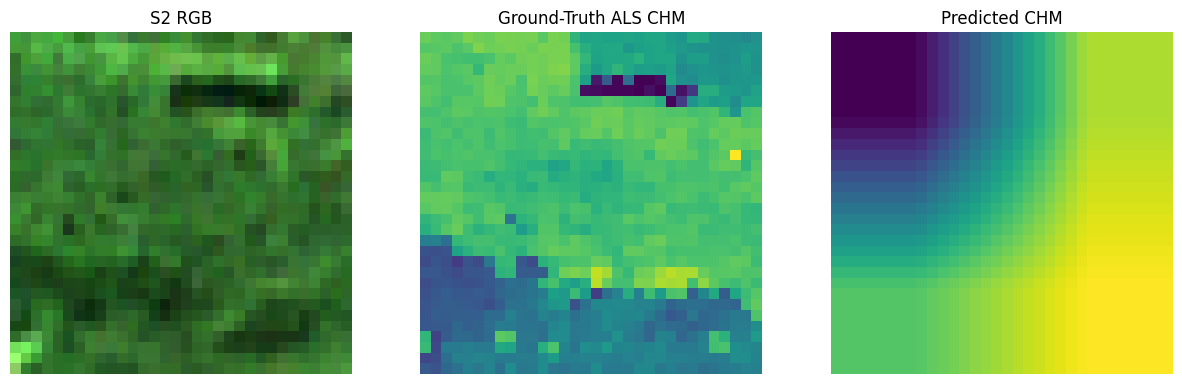

In [26]:
# now show some results, including S2 RGB image
def show_predictions_with_rgb(model, dataloader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            if i >= num_samples:
                break
            y_hat = model(X)
            # S2 RGB: channels 3, 2, 1 (B, G, R) for Sentinel-2
            rgb = X[0, [10, 3, 0]].numpy()
            # Normalize for display
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)
            rgb = np.transpose(rgb, (1, 2, 0))
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            axs[0].imshow(rgb)
            axs[0].set_title('S2 RGB')
            axs[0].axis('off')
            axs[1].imshow(y[0].numpy(), cmap='viridis')
            axs[1].set_title('Ground-Truth ALS CHM')
            axs[1].axis('off')
            axs[2].imshow(y_hat[0].numpy(), cmap='viridis')
            axs[2].set_title('Predicted CHM')
            axs[2].axis('off')
            plt.show()

show_predictions_with_rgb(model, val_loader, num_samples=5)

In [ ]:
from
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
import pytorch_lightning as pl

# Custom ResNet18 for regression
class ResNet18Regression(pl.LightningModule):
    def __init__(self, in_channels=13, out_channels=1, lr=1.5e-3):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        # Get resnet18, no pretrained weights
        self.model = resnet18(weights=None)
        # Change first conv to accept 13 channels
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Remove the classifier, add a conv to output 1 channel
        self.model.fc = nn.Identity()
        self.reg_head = nn.Conv2d(512, out_channels, kernel_size=1)
        
    def forward(self, x):
        # ResNet expects at least 224x224, but we use 32x32, so we skip pooling
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        # Remove maxpool to keep spatial dims
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.reg_head(x)
        # Upsample to 32x32 if needed
        x = F.interpolate(x, size=(32, 32), mode='bilinear', align_corners=False)
        return x.squeeze(1)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Prepare data as torch Dataset
class PatchDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        # X: (13, 32, 32), y: (32, 32)
        return self.X[idx], self.y[idx]

train_ds = PatchDataset(X_train2, y_train2)
val_ds = PatchDataset(X_test2, y_test2)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16)

# Train with PyTorch Lightning
model = ResNet18Regression(in_channels=13, out_channels=1)
trainer = pl.Trainer(max_epochs=40, accelerator='auto')
trainer.fit(model, train_loader, val_loader)

Using device: mps


/Users/felix/miniconda3/envs/CHM/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([288, 1, 32, 32])) that is different to the input size (torch.Size([288, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 1788.5476
Epoch 2, Loss: 3436206.2500
Epoch 3, Loss: 650.7529
Epoch 4, Loss: 800.4772
Epoch 5, Loss: 837.4676
Epoch 6, Loss: 817.8782
Epoch 7, Loss: 782.0016
Epoch 8, Loss: 701.5931
Epoch 9, Loss: 534.0711
Epoch 10, Loss: 405.7231
Epoch 11, Loss: 286.9460
Epoch 12, Loss: 118.1192
Epoch 13, Loss: 142.7122
Epoch 14, Loss: 139.8159
Epoch 15, Loss: 160.1123
Epoch 16, Loss: 112.9681
Epoch 17, Loss: 116.5619
Epoch 18, Loss: 89.9041
Epoch 19, Loss: 98.4824
Epoch 20, Loss: 85.3966
Epoch 21, Loss: 78.2222
Epoch 22, Loss: 65.1924
Epoch 23, Loss: 63.9564
Epoch 24, Loss: 64.1202
Epoch 25, Loss: 67.7970
Epoch 26, Loss: 64.1090
Epoch 27, Loss: 61.7508
Epoch 28, Loss: 58.8488
Epoch 29, Loss: 57.2104
Epoch 30, Loss: 57.7557
Test loss on site 2: 109.3127


/Users/felix/miniconda3/envs/CHM/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64, 1, 32, 32])) that is different to the input size (torch.Size([64, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


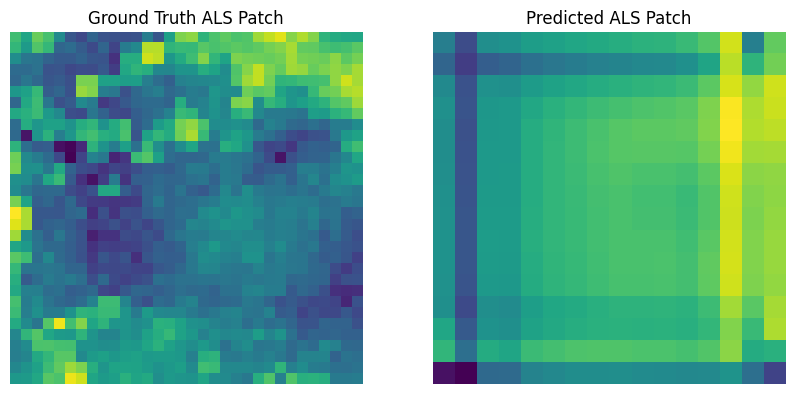

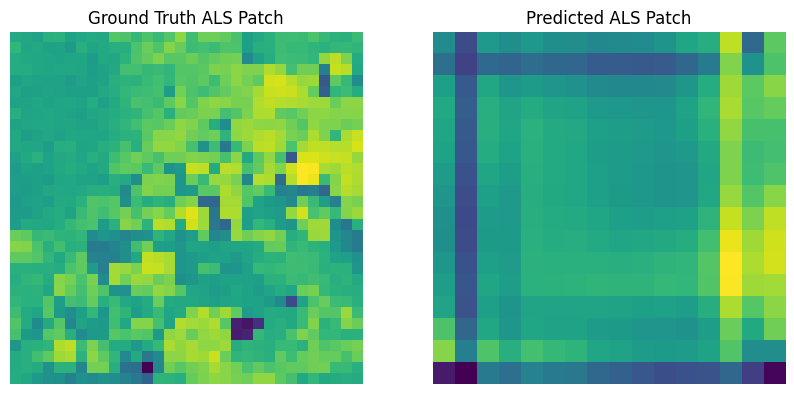

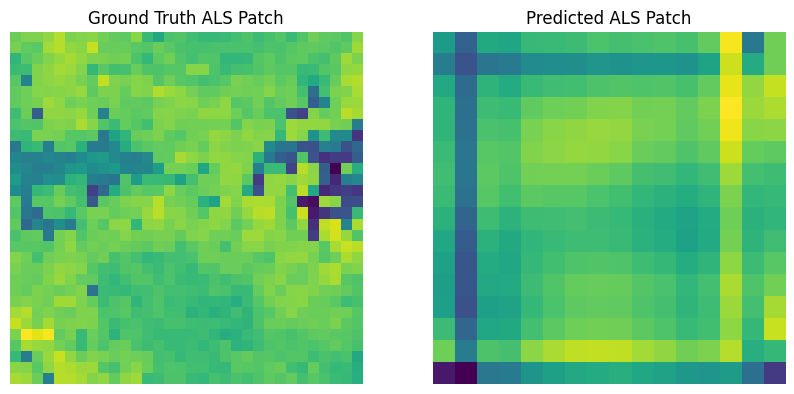

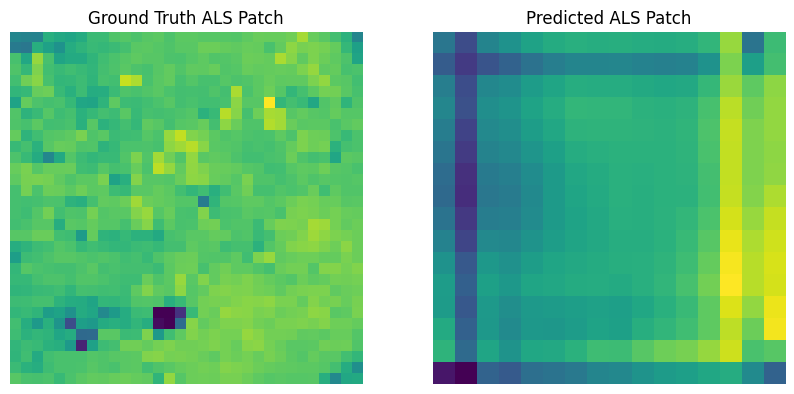

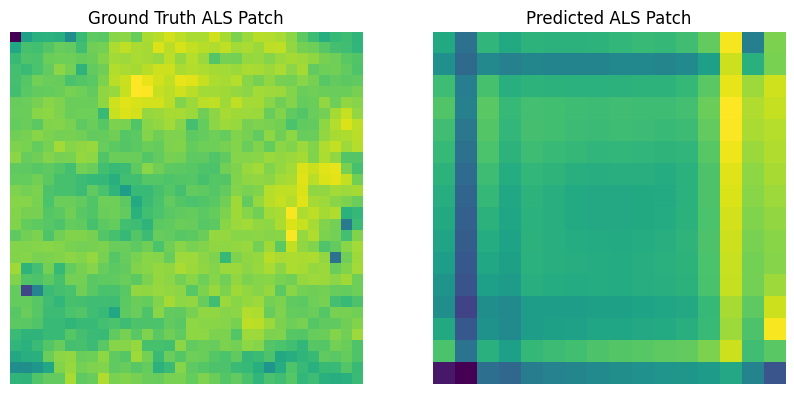

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Select device: MPS if available, else CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Example U-Net-like model for 3D input (channels, height, width)
class SimpleUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleUNet, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.pool1(x1)
        x3 = self.enc2(x2)
        x4 = self.pool2(x3)
        x5 = self.up1(x4)
        x6 = self.dec1(x5)
        x7 = self.up2(x6)
        out = self.final(x7)
        return out

# Prepare data: convert numpy arrays to torch tensors and permute axes to (N, C, H, W)
X_train1_torch = torch.tensor(X_train1, dtype=torch.float32).to(device)
y_train1_torch = torch.tensor(y_train1, dtype=torch.float32).unsqueeze(1).to(device)  # add channel dim

X_test2_torch = torch.tensor(X_test2, dtype=torch.float32).to(device)
y_test2_torch = torch.tensor(y_test2, dtype=torch.float32).unsqueeze(1).to(device)

# If your data is (N, C, H, W), make sure axes are correct
if X_train1_torch.shape[1] != input_shape[0]:
    X_train1_torch = X_train1_torch.permute(0, 1, 2, 3)  # adjust if needed

# Model, loss, optimizer
model = SimpleUNet(in_channels=input_shape[0], out_channels=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3)

# Training loop (simple, 10 epochs)
for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train1_torch)
    loss = criterion(outputs.squeeze(1), y_train1_torch)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test2_torch)
    test_loss = criterion(test_outputs.squeeze(1), y_test2_torch)
    print(f"Test loss on site 2: {test_loss.item():.4f}")

# Save model
torch.save(model.state_dict(), os.path.join(INPUT_FOLDER, "unet_model_site1.pt"))
# Load model for inference
model.load_state_dict(torch.load(os.path.join(INPUT_FOLDER, "unet_model_site1.pt")))
# Inference on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test2_torch)
    test_outputs_np = test_outputs.squeeze(1).cpu().numpy()  # convert to numpy for further processing
# Save predictions
np.save(os.path.join(INPUT_FOLDER, "predictions_site2.npy"), test_outputs_np)
# Visualize some predictions
for i in range(5):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(y_test2[i], cmap='viridis')  # plot ground truth ALS patch
    plt.title("Ground Truth ALS Patch")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(test_outputs_np[i], cmap='viridis')  # assuming single channel output
    plt.title("Predicted ALS Patch")
    plt.axis('off')
    
    plt.show()
# Clean up
del model, X_train1_torch, y_train1_torch, X_test2_torch, y_test2_torch, test_outputs
# Clear cache
torch.cuda.empty_cache() if torch.cuda.is_available() else None
# Final cleanup

In [11]:
X_test2.shape

(64, 13, 32, 32)